In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

from utils import Box, boxes_drawing
from utils import network_to_boxes, img_process
from keras.backend import set_image_dim_ordering
# 保证你使用的通道顺序和配置的通道顺序一致
# more to see : https://github.com/fchollet/keras/issues/2681
set_image_dim_ordering('th')

Using TensorFlow backend.


## build yolo model (tiny yolo model)


In [2]:
from tiny_yolo_model import tiny_yolo

model = tiny_yolo()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________


## load pretrained weights file

this pretrained weights is from COCO image dataset, which is a focus on object recognition within the broader context of scence understanding.

To run the below cell, please download pretrained weights file from [here](https://drive.google.com/file/d/0B1tW_VtY7onibmdQWE1zVERxcjQ/view?usp=sharing) (172MB)

In [3]:
def load_trained_weights(model, weight_file):
                
    weights = np.fromfile(weight_file,np.float32)
    weights = weights[4:]
    
    idx = 0
    for layer in model.layers:
        shape = [wi.shape for wi in layer.get_weights()]
        if shape != []:
            W_shape, b_shape = shape
            bias = weights[idx:idx+np.prod(b_shape)].reshape(b_shape)
            idx += np.prod(b_shape)
            W = weights[idx:idx+np.prod(W_shape)].reshape(W_shape)
            idx += np.prod(W_shape)
            layer.set_weights([W, bias])
            
load_trained_weights(model,'yolo-tiny.weights')

## apply the model to a test image ##

In [4]:
from collections import deque
class Pipeline:
    def __init__(self):
        self.boxes = []
        self.heatmaps = deque(maxlen=8)
        self.first_frames = True
    
    def heatmapping(self, boxes, img):
        # 4帧
        heatmap = np.zeros(img.shape[:2], np.int)
        for b in boxes:
            heatmap[b.top:b.bot, b.left:b.right] += 1
        self.heatmaps.append(heatmap)
        
        # 定义起始帧
        if len(self.heatmaps) > 4:
            self.first_frames = False
        else: 
            self.first_frames = True
            
        
        if not self.first_frames:
            heatmaps = np.zeros(img.shape[:2], np.int)
            for pre_heatmap in self.heatmaps:
                heatmaps = np.add(heatmaps, pre_heatmap)
                
            #if the center point of a box is not in an area the heatmap recognizes, remove that box
            new_boxes = []
            for b in boxes:
                y = (b.bot+b.top)//2
                x = (b.left+b.right)//2
                if heatmaps[y, x] > 2:
                    new_boxes.append(b)
# ------------------------------------------------------------------------
#              f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
#             ax1.imshow(img)
#             ax2.imshow(full_heatmap)
# -----------------------------------------------------------------------------------
            return new_boxes
#--------------------------------------------------------------------------"""
#         f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
#         ax1.imshow(img)
#         ax2.imshow(heatmaps)
#--------------------------------------------------------------------------------"""
        return boxes

    
    def pipeline(self, img):
        # 为了展示原有图片与添加box图片的区别
        copy_img = np.copy(img)
        nor_batch, cut_area = img_process(copy_img)
        # 得到每个网格点的probability
        out1 = model.predict(nor_batch)
        boxes = network_to_boxes(out1[0], copy_img, threshold = 0.17)
        
        boxes = self.heatmapping(boxes, copy_img)

        return boxes_drawing(copy_img,boxes)

box.left= 1003 box.right= 1211
box.top= 405 box.bot= 494
box.left= 815 box.right= 925
box.top= 414 box.bot= 503


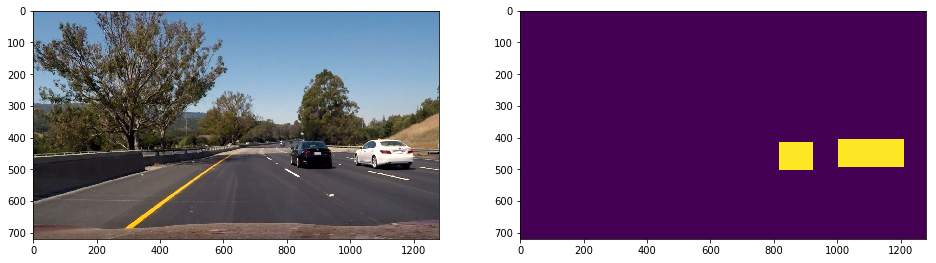

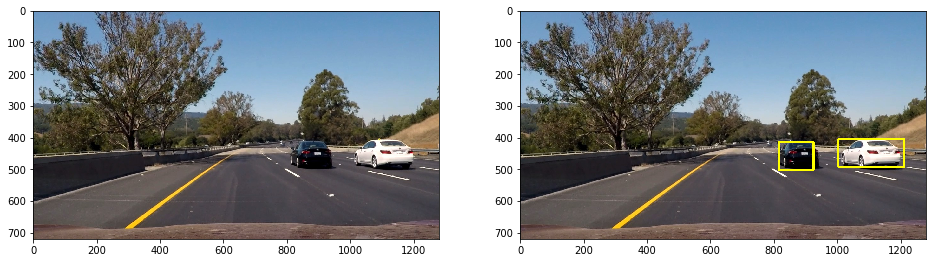

In [5]:
pipe = Pipeline()
test_imgs_path = 'test_images/test6.jpg'
img = plt.imread(test_imgs_path)
boxes_img = pipe.pipeline(img) 
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(img)
ax2.imshow(boxes_img)

more examples

box.left= 809 box.right= 935
box.top= 405 box.bot= 482
box.left= 1030 box.right= 1245
box.top= 398 box.bot= 496
box.left= 858 box.right= 966
box.top= 416 box.bot= 475
box.left= 816 box.right= 923
box.top= 407 box.bot= 477
box.left= 1016 box.right= 1267
box.top= 398 box.bot= 502


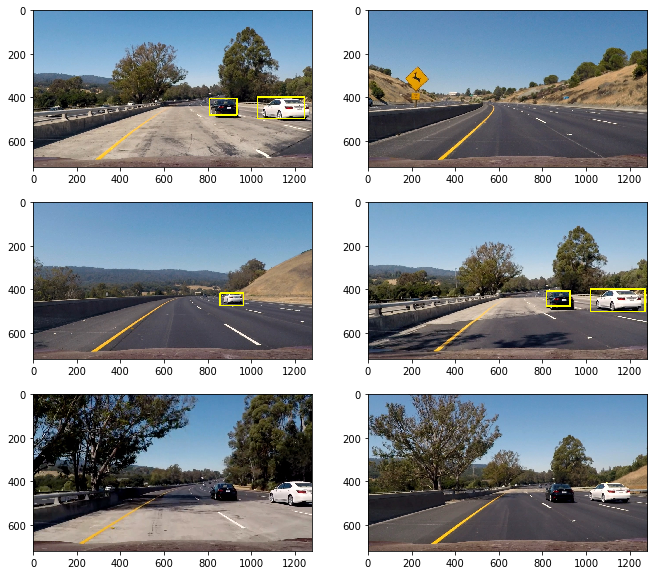

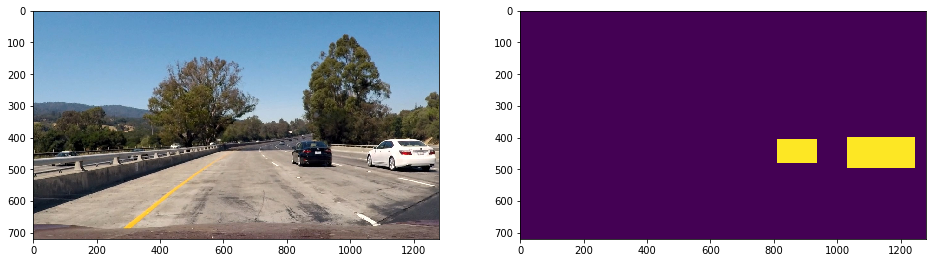

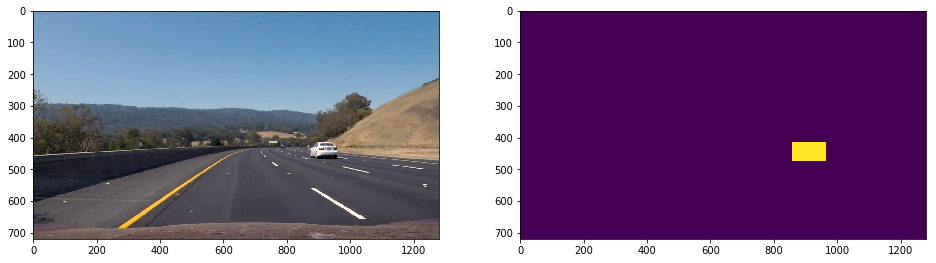

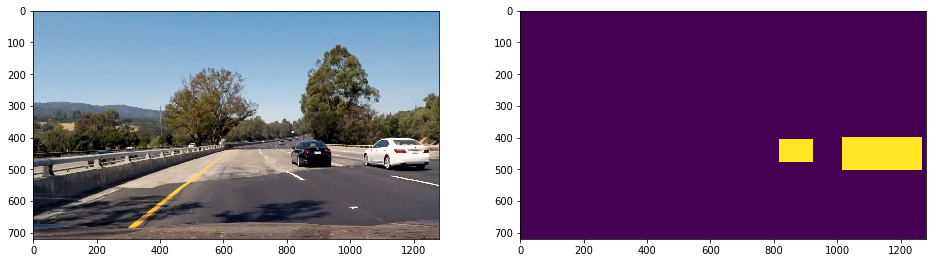

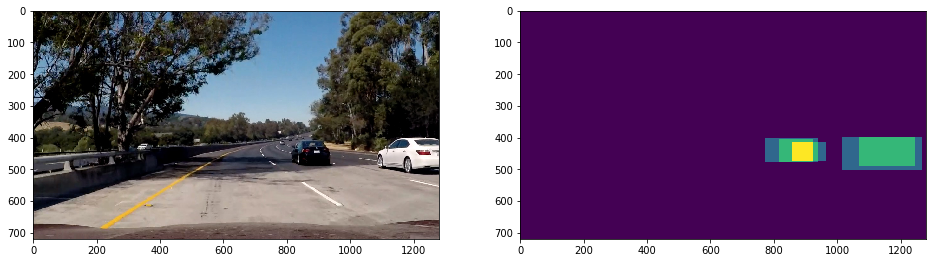

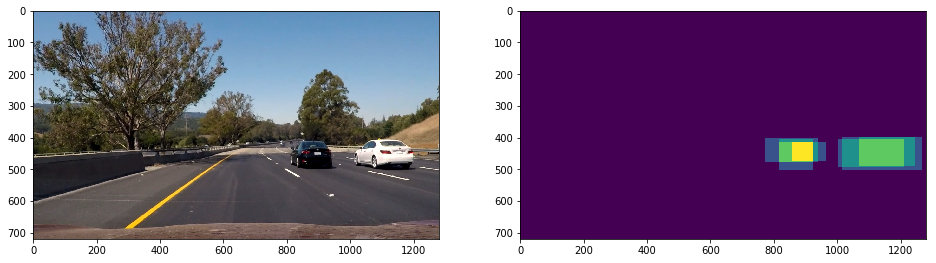

In [6]:
imgs_path =  glob.glob('./test_images/*.jpg')
imgs_list = []
for img_path in imgs_path:
    imgs_list.append(plt.imread(img_path))
num = len(imgs_list)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
pipe2 = Pipeline()
for i,ax in zip(range(num),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes_img = pipe2.pipeline(imgs_list[i])
    ax.imshow(boxes_img)

## Apply detection and lane line finding to video

In [5]:
project_video_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

In [6]:
pipe3 = Pipeline()
lane_clip = clip1.fl_image(pipe3.pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:22<00:00,  9.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2min 23s


## Combine land line finding
video has uploaded to youtube, more to see my github repo.

In [11]:
from LaneFinding.imgs_transf import Undistort, PerspectiveTransform
from LaneFinding.imgs_processing import Processing
from LaneFinding.lines_finding import LinesFinding
from LaneFinding.imgs_drawing import Drawing

In [8]:
line = LinesFinding()

def LaneFinding(img):
    undist = Undistort(img)
    warped = PerspectiveTransform(undist)
    bin_warped = Processing(warped)
    
    if not line.is_found:
        line.window_search(bin_warped)
    else:
        line.direct_search(bin_warped)
    ploty = line.ploty
    leftx = line.left_fitx
    rightx = line.right_fitx
    curve_rad = line.curve_rad
    position = line.position 
    result = Drawing(undist, bin_warped, leftx, rightx, ploty, curve_rad, position)
    return result

pipe2 = Pipeline()
project_video_output = 'project_video_detection_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip2 = clip1.fl_image(LaneFinding)
lane_clip = clip2.fl_image(pipe2.pipeline)
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_detection_out.mp4
[MoviePy] Writing video project_video_detection_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:32<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection_out.mp4 

Wall time: 4min 33s
